### Dyna-Q
Make sure that the total number of learning steps stays the same for different $n$, such that comparisons are fair: $episode * steps * (1+n) = constant$ 
* Dyna-Q, a simple architecture integrating the major functions needed in an online planning agent.
* Within a planning agent, there are at least two roles for real experience: it can be used to improve the model (to make it more accurately match the real environment) and it can be used to directly improve the value function and policy using the kinds of RL methods we have discussed earlier. The former we call model-learning, and the latter we call direct reinforcement learning (direct RL/model-free RL).

**General Dyna Architecture**
* Direct RL method: Any model free algorithm (Q-learning, SARSA).
* Indirect RL method: Model learning and search control.

![](dyna_q.png)
![](Dyna-Q-model.png)

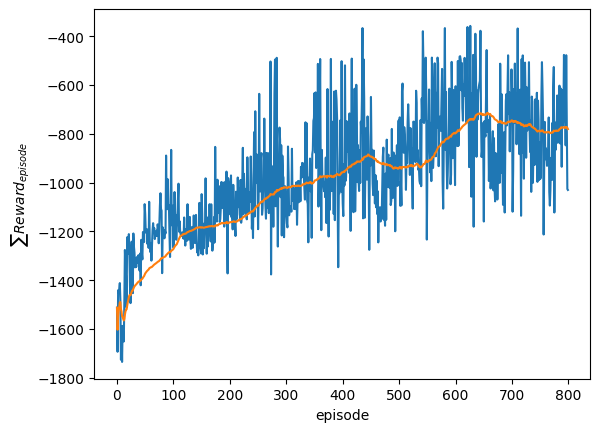

In [2]:
import os
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import PendulumEnv

env = PendulumEnv()
n = 30 # planning steps per real step 
gamma = 0.9 # discount factor
alpha = 0.1 # constant step size
epsilon = 0.1 # this is the probability, that we'll not take the action from given policy but we'll take random actions
"""If epsilon=0, means we have greedy policy and if epsilon=1, means we'll only take random action. Thats, why we call it exploration parameter"""

q = np.zeros([env.d_omega, env.d_torque, env.d_theta * env.d_theta]) # Defining an empty state-action value matrix (layer=omega, row=torque, column=x*y)

# INPUT -> TD(0) method is initialized with a random policy
policy = np.random.randint(0, env.d_torque, size=(env.d_omega, env.d_theta, env.d_theta)).astype(int) # Initial random Policy (layer,row,column)

cumulative_reward_list = []
avg_reward_history = []

non_greedy_prob = epsilon / env.d_torque # Probability of all non-greedy action
greedy_prob = 1 - epsilon + non_greedy_prob # Probability of all greedy action

tot_episodes = 800 # no of eposides
time_step_for_task = 200 # time steps required to perform a task in one episode

M = {} # Defining an empty Model

for current_episode in range(tot_episodes):
    reward_list = []
    
    initial_state = env.reset() # Reset and return the first observation x_{k}

    discrete_state = tuple(env.discretize_state(initial_state)) 

    # Now we can run for some time step within the episode
    for k in range(time_step_for_task): 
        greedy_action = policy[discrete_state[2],discrete_state[0],discrete_state[1]] # exploitative action

        # Take the action using epsilon-greedy
        weight_array = non_greedy_prob*np.ones((env.d_torque)) # The weights of all non-greedy actions are equal to non-greedy probability
        weight_array[greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

        # Take the action using epsilon-greedy Policy
        """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
        discrete_action = np.random.choice(env.d_torque, 1, p=weight_array)[0] # u_{k} 
        
        continuous_action = env.continualize_action(discrete_action)

        continuous_state,reward = env.step(continuous_action) # performing action u_{k} and observing x_{k+1} and r_{k+1}

        reward_list.append(reward) # Saving reward, r_{k+1}

        new_discrete_state = tuple(env.discretize_state(continuous_state))

        x_1,y_1,omega_1 = discrete_state
        x_2,y_2,omega_2 = new_discrete_state

        q[omega_1, discrete_action, env.d_theta*x_1 + y_1] += alpha * (reward + gamma * np.max(q[omega_2, :, env.d_theta*x_2 + y_2]) - q[omega_1, discrete_action, env.d_theta*x_1 + y_1]) # q(x_{k},u_{k}) -> new
            
        policy[omega_1, x_1, y_1] = np.argmax(q[omega_1, :, env.d_theta*x_1 + y_1])

        M[discrete_state, discrete_action] = (new_discrete_state, reward) # fiiling data in model

        discrete_state = new_discrete_state

        if current_episode > 0: # Neglect first episode, because, we will get our first model after completing first episode
            for _ in range(n):
                X_tilda, U_tilda = random.sample(M.keys(), 1)[0] # randomly sample a state, action pair from the visited states and action, saved in model 
                X_new_tilda, reward_tilda = M[X_tilda, U_tilda]

                x_1_tilda,y_1_tilda,omega_1_tilda = X_tilda
                x_2_tilda,y_2_tilda,omega_2_tilda = X_new_tilda

                q[omega_1_tilda, U_tilda, env.d_theta*x_1_tilda + y_1_tilda] += alpha * (reward_tilda + gamma*np.max(q[omega_2_tilda, :, env.d_theta*x_2_tilda + y_2_tilda]) - q[omega_1_tilda, U_tilda, env.d_theta*x_1_tilda + y_1_tilda])

                policy[omega_1_tilda, x_1_tilda, y_1_tilda] = np.argmax(q[omega_1_tilda, :, env.d_theta*x_1_tilda + y_1_tilda])
             
    cumulative_reward_list.append(np.sum(reward_list))
    avg_reward = np.mean(cumulative_reward_list[-100:])
    avg_reward_history.append(avg_reward) 

# Planning leads to the agent interacting less often with the "real" environment, such that in the end fewer interaction time is needed.
plt.plot(cumulative_reward_list)
plt.plot(avg_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum Reward_{episode}$")
plt.show()

#### Greedy Execution of above optimal policy
Test the learned optimal policy by pure greedy execution.

In [3]:
import csv

Initial_state = env.reset() # initialize x_0
discrete_state = tuple(env.discretize_state(Initial_state)) # use tuple indexing
discrete_action = policy[discrete_state[2], discrete_state[0], discrete_state[1]]
pendulum_plot = [(initial_state[0], initial_state[1])]
plot_torque = [np.array([0])]

for k in range(200):
        
    continuous_action = env.continualize_action(discrete_action)
    continuous_state, reward = env.step(continuous_action)

    pendulum_plot.append((continuous_state[0], continuous_state[1]))
    plot_torque.append(continuous_action)

    discrete_state = tuple(env.discretize_state(continuous_state))
        
    discrete_action = policy[discrete_state[2], discrete_state[0], discrete_state[1]] # exploitative action

# Save the state data as ".csv" for plotting
with open("pendulum_by_Dyna_Q.csv",'w') as csvfile:  
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(pendulum_plot) 